# Notebook Setup

Markdown comments = thoughts on high-level, project-management-esque decisions

`# Inline or cell-blocked code comments = thoughts on low-level, coding/optimization decisions `

In [59]:
# Imports
import sys
sys.path.append("../modules/")
import imports
import helper
import evaluate

In [60]:
# To see a full list of my imports, functions, and global variables, see ../modules/

In [61]:
# Loading data
filename = "cleaned_featured_data"
filepath = f"{imports.DEV_PATH_TO_PREPPED_DATA}/{filename}.csv"
df = imports.pd.read_csv(filepath)

# Modeling

## Reasoning: Logistic Regression

Going to start with **logistic regression** (LR) to tackle a binary classifier because LR is:
- simple/interpretable model, which is useful in the regulatory context where transparency is highly important
- very effective with binary classification, especially if the boundary between classes is linearly separable
- handles BOTH categorical and numerical data well, which is pertinent to our specific case because our dataset has ample amounts of both
- relatively fast compared to more complex models like a neural network
- has built in feature importance identification through coefficients to help us determine which features are important (which is one of the questions the client has asked to report on)
- in general a good baseline and starting ML model to compare other models against

## General Data Setup

In [62]:
# Defining variables for in/dependent variables
drop_cols = ["inspection_id",
             "serious_violation"]
dep_col = "serious_violation"
pos_class_name = "Serious Violation"
neg_class_name = "No Serious Violation"

# Defining ratios
train_ratio = imports.DEFAULT_TRAIN
validation_ratio = imports.DEFAULT_VAL
test_ratio = imports.DEFAULT_TEST

# Instantiate model
model = imports.LogisticRegression(random_state=imports.RANDOM_SEED)
optimizer_score = "precision"
folds = imports.DEFAULT_FOLDS

# Adjust the gridsearch hyperparamaters
log_reg_params = {"C": [0.001, 0.01, 0.1, 1, 10, 100],
                  "solver": ["newton-cg", "lbfgs", "liblinear", "sag", "saga"],
                  "max_iter": [100, 300, 500, 800, 1000, 3000]}

In [63]:
# Preparing the data for logistic regression
X = df.drop(drop_cols, axis=1)
y = df[dep_col]

In [64]:
# Columns that need different preprocessing
print(X.columns)
categorical_features = ["asian", "ethnic", "season_Spring", "season_Summer", "season_Winter"]
numerical_features = ["inspection_average_prev_penalty_scores", "number_of_cuisines", "inspection_duration (days)", "sentiment_score", "perc_non_positive_review_count", "review_trend"]

Index(['inspection_average_prev_penalty_scores', 'asian', 'ethnic',
       'number_of_cuisines', 'inspection_duration (days)', 'season_Spring',
       'season_Summer', 'season_Winter', 'sentiment_score',
       'perc_non_positive_review_count', 'review_trend'],
      dtype='object')


In [65]:
# Creating df to store all the model scores from perspective of class 1 (aka the serious violation class)
# We focus on class 1 metrics due to regulatory context
index_name = "dummy_model"
tracked_metrics = ["precision", "recall", "f1-score", "accuracy", "auc"] 
all_scores = imports.pd.DataFrame(columns=tracked_metrics, 
                                  data=[imports.np.zeros(len(tracked_metrics))], 
                                  index=[index_name])
all_scores

,precision,recall,f1-score,accuracy,auc
dummy_model,0.0,0.0,0.0,0.0,0.0


In [66]:
# we need a dummy row for this df due a pandas warning; in future it won't allow concat w empty dfs or dfs w only nans

## Modeling w/ MinMax 

### Data Preprocessing

In [67]:
# Setup overall model name
model_name = "Logistic Regression MinMax"

In general, scaling our data helps reduce the disproportionate impact of very large mangitude differences between independent variables. For example, the range of reviews a restaurant receives could between 0-100k, while the rating for a restaurant ranges from 1-5. In regression models, these magnitudes are treated equally, so a rating of 1-5 would always have a small influence compared to the number of reviews. Scaling would ensure these numerical values are treated the same.

Likewise, we do not scale categorical data, because 0,1 for categorical data does not represent an actual numerical meaning beyond being a boolean signifier.

In [68]:
# Setup preprocessor
transformers = [("num", imports.MinMaxScaler(), numerical_features),
                ("cat", "passthrough", categorical_features)] # do nothing to cat features
preprocessor = imports.ColumnTransformer(transformers)

# Scale data
fitted_preprocessor = preprocessor.fit(X)
X_scaled = fitted_preprocessor.transform(X)

# Save the fitted preprocessor
filepath = f"{imports.DEV_PATH_TO_SAVED_MODELS}/preprocessor_{model_name.replace(" ", "_").lower()}.pkl"
imports.joblib.dump(fitted_preprocessor, filepath)

# Split data -> train/test
X_train, X_test, y_train, y_test = imports.train_test_split(X_scaled, y, 
                                                            test_size=(1 - train_ratio), 
                                                            random_state=imports.RANDOM_SEED)
# Split test -> test/val
X_val, X_test, y_val, y_test = imports.train_test_split(X_test, y_test, 
                                                        test_size=test_ratio/(test_ratio + validation_ratio), 
                                                        random_state=imports.RANDOM_SEED)

Doing a train/val/test split to ensure we can properly evaluate models. Specifically, since I'll be using different model variants, I can use the models' validation scores to select the best one to then simulate a deployment performance on the test data.

### Train / Predict

One of the benefits of a logistic regression is its relative compute speed. This enables us to freely use gridsearch techniques to brute force out the best possible models.

In [69]:
# Creating the grid_search "model"
grid_search_mm = imports.GridSearchCV(estimator=model, 
                                      param_grid=log_reg_params, 
                                      cv=folds, 
                                      scoring=optimizer_score)

# Fitting the model with the best parameters
grid_search_mm.fit(X_train, y_train)

# Best parameters
print(f"Best Parameters: {grid_search_mm.best_params_}")

Best Parameters: {'C': 0.1, 'max_iter': 100, 'solver': 'sag'}


In [70]:
# Use the best estimator for making predictions
best_model_mm = grid_search_mm.best_estimator_
y_pred = best_model_mm.predict(X_val)
y_pred_prob = best_model_mm.predict_proba(X_val)[:, 1]

### Evaluation (on Validation)

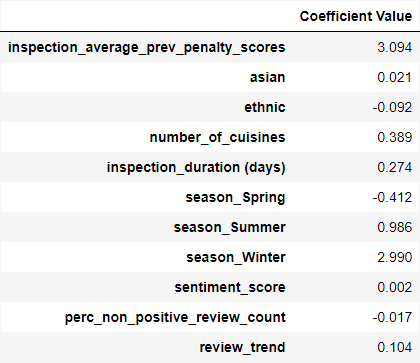

In [71]:
# Extracting the coefficients to see feature importance, a benefit of the LR model
feature_labels = X.columns.to_list()
evaluate.graph_coefficients(best_model_mm, feature_labels, model_name)

From coefficients, it seems like `inspection_average_prev_penalty_scores` and `season_Winter` are the 2 strongest variables that affect the prediction, with values 3.059 and 2.993 respectively.

However, recalling that we dropped the `season_Fall` due to multicollinearity, we should interpret these results with respect to fall. Thus, we can say that a restaurant is close to 3 times more likely (in log-odds) to receive a serious violation in winter than in fall. If seasonality had no effect on the predictions, we would see these results be around 1.0. In essence, this tells us that assessments during the winter seem to be more likely to predict noncompliance.

Likewise, we see that restaurants that have consistently scored low in the past (resulting in average low penalty scores) continue to have low penalty scores moving forward. This variable plays a big role in our logistic model prediction as well. 

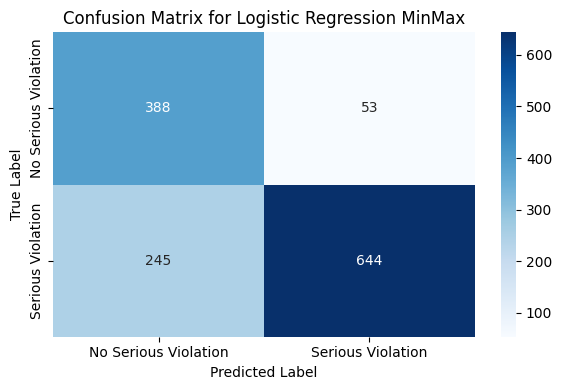

array([[388,  53],
       [245, 644]], dtype=int64)

In [72]:
# Confusion Matrix
evaluate.graph_confusion_matrix(y_val, y_pred, pos_class_name, neg_class_name, model_name)

The confusion matrix gives us the raw count/the distribution of Type I,II error instances.

In this case, we see that the model only has 53 cases (just 3.9% of all cases) of falsely labeling a restaurant as a serious violator (called a Type I error), which is a very important score the regulatory context. For example, it is much more problematic to accidentally convict an innocent of a crime they did not do than it is to accidentally label a criminal as innocent. We optimized our model specifically for decreasing Type I errors. 

Note: the trade-off against Type I errors is that the model is more likely to make Type II errors, which is the case of accidentally predicting a violating restaurant as safe. However, with just 245 cases (18.6% of all cases) of this Type II error, this is still overall an effective model.

We can look at specific model performance metrics in the classification report to learn more.

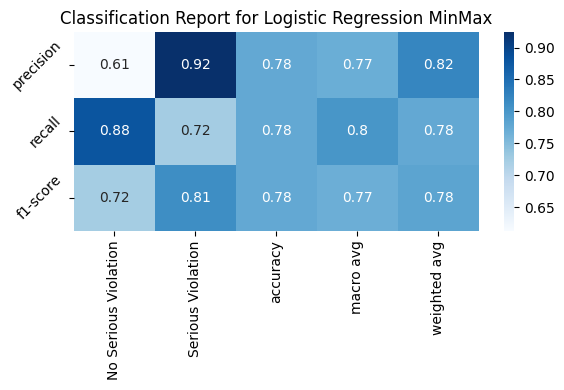

In [73]:
# Classification Report
class_df = evaluate.graph_classification_report(y_val, y_pred, pos_class_name, neg_class_name, model_name)

As mentioned above, our model does very well with Type I errors, which is reflected with a high precision score of 0.92. Likewise, it is a strong model overall, as demonstrated with the balanced F1-score of 0.81. 

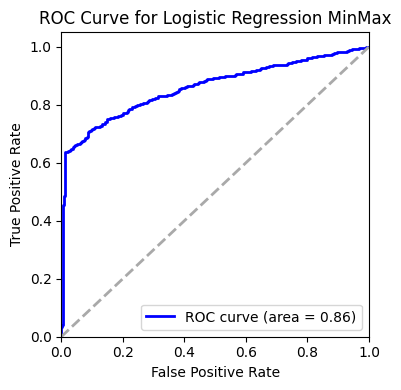

In [74]:
# ROC Curve
roc_auc_score = evaluate.graph_roc(y_val, y_pred_prob, model_name)

The ROC gives a summarized and visual "single point of truth" that aggregates overall performance. Specifically, ROC gives insight into the trade-off between TPR (recall) and FPR rates at different thresholds. The ROC also does not depend on class distribution (which from our intial dataset exploration, we know is a 67-33 imbalance between the classes), which is an added advantage over the traditional classification report metrics.

From the results, we see the area under the curve to be 0.86, which is strong general score. The model is very good at distinguishing between the compliance and non-complaince.

In [75]:
# Storing values
scores_df = {tracked_metrics[0]: class_df[tracked_metrics[0]][pos_class_name],
             tracked_metrics[1]: class_df[tracked_metrics[1]][pos_class_name],
             tracked_metrics[2]: class_df[tracked_metrics[2]][pos_class_name],
             tracked_metrics[3]: class_df["precision"]["accuracy"], # hard coding accuracy because it has different structure in df; makes it easier to debug
             tracked_metrics[4]: roc_auc_score} 
scores_df = imports.pd.DataFrame(scores_df, index=[model_name])
all_scores = imports.pd.concat([all_scores, scores_df], axis=0)
all_scores.drop(index_name, inplace=True) # excluding the dummy row, we created the empty df in the "general datasetup" for making it easier to track where that df is created
all_scores

,precision,recall,f1-score,accuracy,auc
Logistic Regression MinMax,0.92396,0.724409,0.812106,0.77594,0.859987


## Modeling w/ StandardScaler 

### Data Preprocessing

In [76]:
# Setup overall model name
model_name = "Logistic Regression Standard"

In [77]:
# Setup preprocessor
transformers = [("num", imports.StandardScaler(), numerical_features),
                ("cat", "passthrough", categorical_features)] # do nothing to cat features
preprocessor = imports.ColumnTransformer(transformers)

# Scale data
fitted_preprocessor = preprocessor.fit(X)
X_scaled = fitted_preprocessor.transform(X)

# Save the fitted preprocessor
filepath = f"{imports.DEV_PATH_TO_SAVED_MODELS}/preprocessor_{model_name.replace(" ", "_").lower()}.pkl"
imports.joblib.dump(fitted_preprocessor, filepath)

# Split data -> train/test
X_train, X_test, y_train, y_test = imports.train_test_split(X_scaled, y, 
                                                            test_size=(1 - train_ratio), 
                                                            random_state=imports.RANDOM_SEED)
# Split test -> test/val
X_val, X_test, y_val, y_test = imports.train_test_split(X_test, y_test, 
                                                        test_size=test_ratio/(test_ratio + validation_ratio), 
                                                        random_state=imports.RANDOM_SEED)

### Train / Predict

In [78]:
# Creating the grid_search "model"
grid_search_ss = imports.GridSearchCV(estimator=model, 
                                      param_grid=log_reg_params, 
                                      cv=folds, 
                                      scoring=optimizer_score)

# Fitting the model with the best parameters
grid_search_ss.fit(X_train, y_train)

# Best parameters
print(f"Best Parameters: {grid_search_ss.best_params_}")

c:\Users\chris\anaconda3\envs\work\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\chris\anaconda3\envs\work\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\chris\anaconda3\envs\work\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\chris\anaconda3\envs\work\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\chris\anaconda3\envs\work\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\chris\anaconda3\envs\work\Lib\site-packages\sklearn

Best Parameters: {'C': 100, 'max_iter': 100, 'solver': 'newton-cg'}


In [79]:
# Use the best estimator for making predictions
best_model_ss = grid_search_ss.best_estimator_
y_pred = best_model_ss.predict(X_val)
y_pred_prob = best_model_ss.predict_proba(X_val)[:, 1]

### Evaluation (on Validation)

Analysis of results mirror those done for the minmax model. Rather than explaining every segment, I will summarize the results at the end.

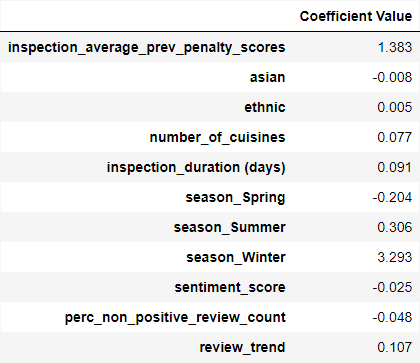

In [80]:
# Extracting the coefficients to see feature importance, a benefit of the LR model
feature_labels = X.columns.to_list()
evaluate.graph_coefficients(best_model_ss, feature_labels, model_name)

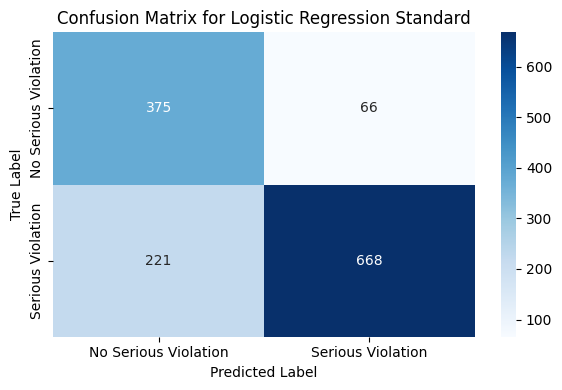

array([[375,  66],
       [221, 668]], dtype=int64)

In [81]:
# Confusion Matrix
evaluate.graph_confusion_matrix(y_val, y_pred, pos_class_name, neg_class_name, model_name)

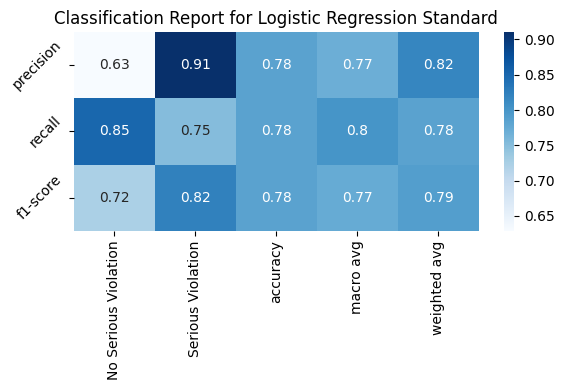

In [82]:
# Classification Report
class_df = evaluate.graph_classification_report(y_val, y_pred, pos_class_name, neg_class_name, model_name)

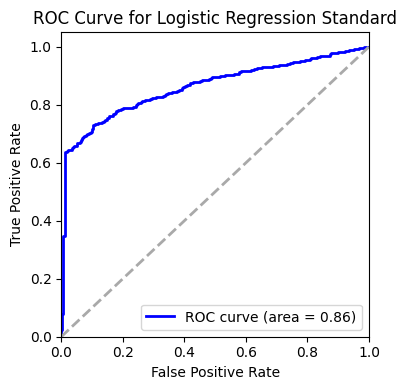

In [83]:
# ROC Curve
roc_auc_score = evaluate.graph_roc(y_val, y_pred_prob, model_name)

In [84]:
# Storing values
scores_df = {tracked_metrics[0]: class_df[tracked_metrics[0]][pos_class_name],
             tracked_metrics[1]: class_df[tracked_metrics[1]][pos_class_name],
             tracked_metrics[2]: class_df[tracked_metrics[2]][pos_class_name],
             tracked_metrics[3]: class_df["precision"]["accuracy"], # hard coding accuracy because it has different structure in df; makes it easier to debug
             tracked_metrics[4]: roc_auc_score} 
scores_df = imports.pd.DataFrame(scores_df, index=[model_name])
all_scores = imports.pd.concat([all_scores, scores_df], axis=0)
all_scores

,precision,recall,f1-score,accuracy,auc
Logistic Regression MinMax,0.923960,0.724409,0.812106,0.775940,0.859987
Logistic Regression Standard,0.910082,0.751406,0.823167,0.784211,0.862385


## Modeling w/ RobustScaler

### Data Preprocessing

In [85]:
# Setup overall model name
model_name = "Logistic Regression Robust"

In [86]:
# Setup preprocessor
transformers = [("num", imports.RobustScaler(), numerical_features),
                ("cat", "passthrough", categorical_features)] # do nothing to cat features
preprocessor = imports.ColumnTransformer(transformers)

# Scale data
fitted_preprocessor = preprocessor.fit(X)
X_scaled = fitted_preprocessor.transform(X)

# Save the fitted preprocessor
filepath = f"{imports.DEV_PATH_TO_SAVED_MODELS}/preprocessor_{model_name.replace(" ", "_").lower()}.pkl"
imports.joblib.dump(fitted_preprocessor, filepath)

# Split data -> train/test
X_train, X_test, y_train, y_test = imports.train_test_split(X_scaled, y, 
                                                            test_size=(1 - train_ratio), 
                                                            random_state=imports.RANDOM_SEED)
# Split test -> test/val
X_val, X_test, y_val, y_test = imports.train_test_split(X_test, y_test, 
                                                        test_size=test_ratio/(test_ratio + validation_ratio), 
                                                        random_state=imports.RANDOM_SEED)

### Train / Predict

In [87]:
# Creating the grid_search "model"
grid_search_rs = imports.GridSearchCV(estimator=model, 
                                      param_grid=log_reg_params, 
                                      cv=folds, 
                                      scoring=optimizer_score)

# Fitting the model with the best parameters
grid_search_rs.fit(X_train, y_train)

# Best parameters
print(f"Best Parameters: {grid_search_rs.best_params_}")

c:\Users\chris\anaconda3\envs\work\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\chris\anaconda3\envs\work\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\chris\anaconda3\envs\work\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\chris\anaconda3\envs\work\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\chris\anaconda3\envs\work\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\chris\anaconda3\envs\work\Lib\site-packages\sklearn

Best Parameters: {'C': 100, 'max_iter': 300, 'solver': 'lbfgs'}


In [88]:
# Use the best estimator for making predictions
best_model_rs = grid_search_rs.best_estimator_
y_pred = best_model_rs.predict(X_val)
y_pred_prob = best_model_rs.predict_proba(X_val)[:, 1]

### Evaluation (on Validation)

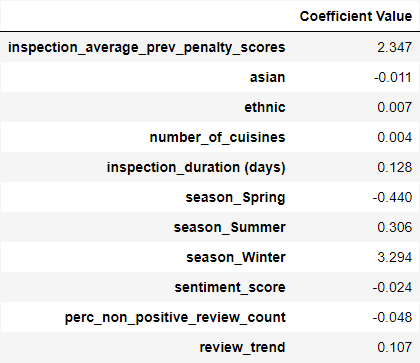

In [89]:
# Extracting the coefficients to see feature importance, a benefit of the LR model
feature_labels = X.columns.to_list()
evaluate.graph_coefficients(best_model_rs, feature_labels, model_name)

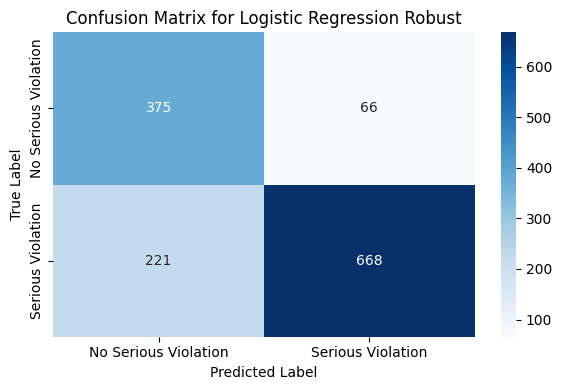

array([[375,  66],
       [221, 668]], dtype=int64)

In [90]:
# Confusion Matrix
evaluate.graph_confusion_matrix(y_val, y_pred, pos_class_name, neg_class_name, model_name)

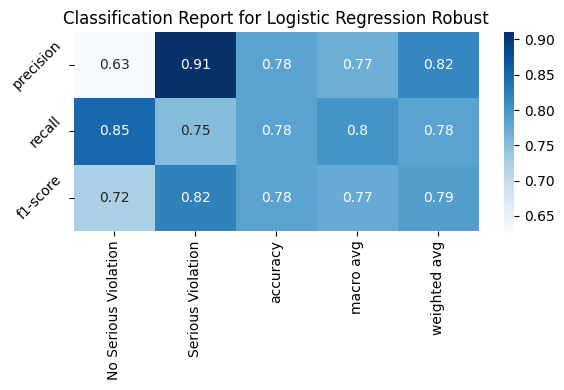

In [91]:
# Classification Report
class_df = evaluate.graph_classification_report(y_val, y_pred, pos_class_name, neg_class_name, model_name)

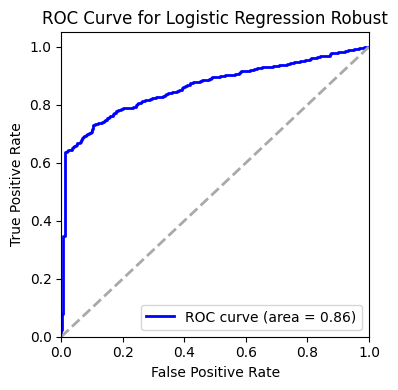

In [92]:
# ROC Curve
roc_auc_score = evaluate.graph_roc(y_val, y_pred_prob, model_name)

In [93]:
# Storing values
scores_df = {tracked_metrics[0]: class_df[tracked_metrics[0]][pos_class_name],
             tracked_metrics[1]: class_df[tracked_metrics[1]][pos_class_name],
             tracked_metrics[2]: class_df[tracked_metrics[2]][pos_class_name],
             tracked_metrics[3]: class_df["precision"]["accuracy"], # hard coding accuracy because it has different structure in df; makes it easier to debug
             tracked_metrics[4]: roc_auc_score} 
scores_df = imports.pd.DataFrame(scores_df, index=[model_name])
all_scores = imports.pd.concat([all_scores, scores_df], axis=0)
all_scores

,precision,recall,f1-score,accuracy,auc
Logistic Regression MinMax,0.923960,0.724409,0.812106,0.775940,0.859987
Logistic Regression Standard,0.910082,0.751406,0.823167,0.784211,0.862385
Logistic Regression Robust,0.910082,0.751406,0.823167,0.784211,0.862379


## Performance Comparisons

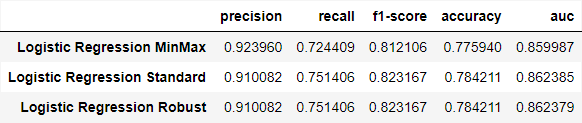

In [94]:
# Saving all scores
filepath = f"{imports.DEV_PATH_TO_MODEL}/total_model_performance.csv"
all_scores.to_csv(filepath)
filepath = f"{imports.DEV_PATH_TO_MODEL}/total_model_performance.png"
imports.dfi.export(all_scores, filepath)
imports.Image(filepath)

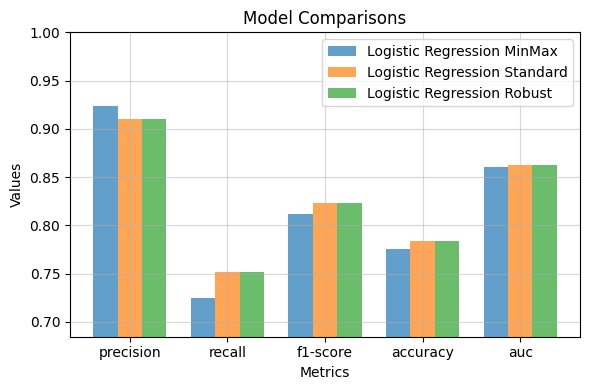

In [95]:
# Graphing the differences
evaluate.graph_bar_comparison(all_scores, "Model Comparisons", "Metrics", "Values")

From our validation evaluations, the MinMax logistic regression model variant scored the highest on precision. Given the context of this problem, we will pick this model variant even if the other two variants are slightly better performers overall. 

To note, the Standard and Robust scalars scored very similarly, suggesting that their preprocessing had a similar effect on this particular dataset.

## Model Evaluation (on Test)

In [96]:
# `best_model_mm` is the winning model; running on test data
y_pred = best_model_mm.predict(X_test)
y_pred_prob = best_model_mm.predict_proba(X_test)[:, 1]

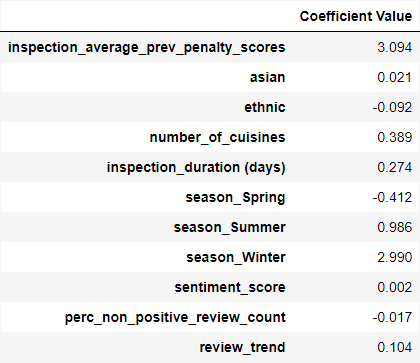

In [97]:
# Revisiting coefficients of this best model
feature_labels = X.columns.to_list()
model_name = "Logistic Regression Final"
evaluate.graph_coefficients(best_model_mm, feature_labels, model_name)

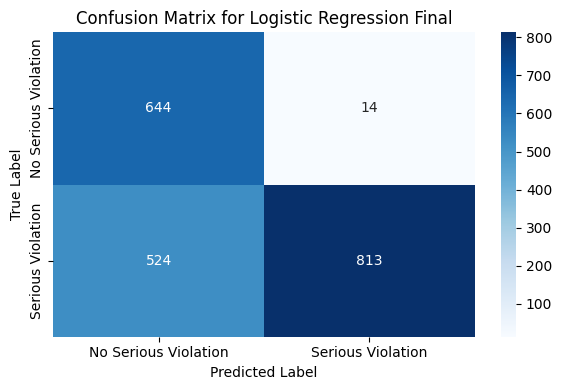

array([[644,  14],
       [524, 813]], dtype=int64)

In [98]:
# Confusion Matrix
evaluate.graph_confusion_matrix(y_test, y_pred, pos_class_name, neg_class_name, model_name)

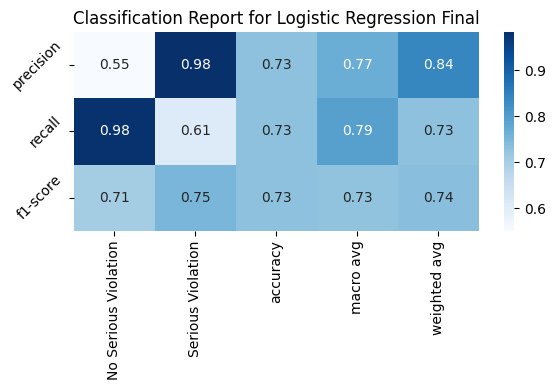

In [99]:
# Classification Report
class_df = evaluate.graph_classification_report(y_test, y_pred, pos_class_name, neg_class_name, model_name)

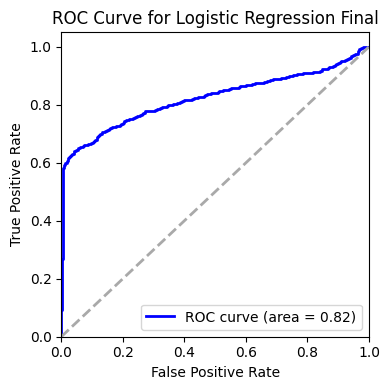

In [100]:
# ROC Curve
roc_auc_score = evaluate.graph_roc(y_test, y_pred_prob, model_name)

In [101]:
# Storing values
scores_df = {tracked_metrics[0]: class_df[tracked_metrics[0]][pos_class_name],
             tracked_metrics[1]: class_df[tracked_metrics[1]][pos_class_name],
             tracked_metrics[2]: class_df[tracked_metrics[2]][pos_class_name],
             tracked_metrics[3]: class_df["precision"]["accuracy"], # hard coding accuracy because it has different structure in df; makes it easier to debug
             tracked_metrics[4]: roc_auc_score} 
scores_df = imports.pd.DataFrame(scores_df, index=[model_name])
all_scores = imports.pd.concat([all_scores, scores_df], axis=0)
final_scores = all_scores.iloc[[0, -1]] # extracting just the validation and testing of minmax model
final_scores

,precision,recall,f1-score,accuracy,auc
Logistic Regression MinMax,0.923960,0.724409,0.812106,0.775940,0.859987
Logistic Regression Final,0.983071,0.608078,0.751386,0.730326,0.823865


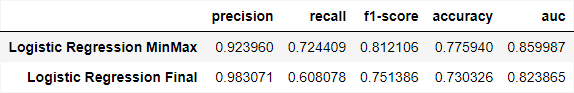

In [102]:
# Saving comparison
filepath = f"{imports.DEV_PATH_TO_MODEL}/final_model_performance.csv"
final_scores.to_csv(filepath)
filepath = f"{imports.DEV_PATH_TO_MODEL}/final_model_performance.png"
imports.dfi.export(final_scores, filepath)
imports.Image(filepath)

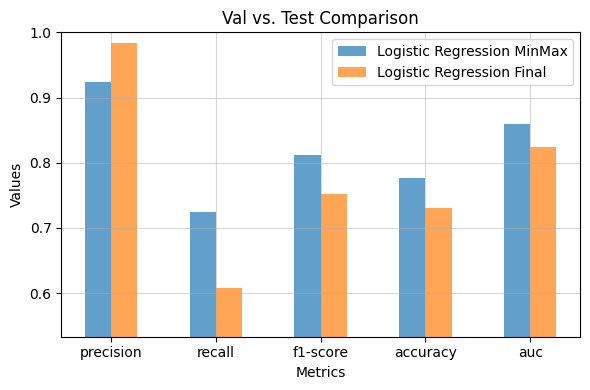

In [103]:
# Graphing the differences
evaluate.graph_bar_comparison(final_scores, "Val vs. Test Comparison", "Metrics", "Values")

Once deploying the model onto the test data, we see that the model actually performs extremely well on precision. The model is slightly overfit to our training data though, as we see decreases in performance on the testing data. Ways to correct overfitting beyond the methods we've already tried would be to emphasize regularization during the training phase or increase the number of folds in cross-validation. 

However, overfitting may not be a problem in this case. Considering the primary optimization metric was for precision, the model is a strong candidate for deployment in an ensemble system. In particular, this model can be used to double-check *other* models against their Type I errors, and in conjunction, result in more informative advice for policy/compliance decisions. For example, if another source (model or person) predicts that an establishment for noncompliance, we can deploy this model to double-check that prediction before any decisions are actually made. Once again, given the context, it is critical that Type I errors suppressed, as it is far worse to penalize a compliant restaurant than it is to overlook a noncompliant restaurant.  

Dependent on the goals of the organization, this logistic model can also easily be retrained for a more balanced approach or for an entirely different metric (e.g. for recall) if precision ends up not being the priority.

# Exporting Model

In [104]:
# Save your model
final_model_name = "Logistic Regression Final"
filepath = f"{imports.DEV_PATH_TO_SAVED_MODELS}/{final_model_name.replace(" ", "_").lower()}.pkl"
imports.joblib.dump(best_model_mm, filepath)

['../outputs/saved_models/logistic_regression_final.pkl']